Preprocessing - images were inconsistent in size, contrast, noise, and brightness, so I hard to standardize and normalize and reduce noise. Also made the tumor areas brighter, and sharpened the edges for a clearer image.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
MODERATE PREPROCESSING WITH TUMOR SEGMENTATION
Starting moderate preprocessing with tumor segmentation...
Found 903 images to process

Configuration:
   Brightness boost: +20%
   CLAHE clip limit: 1.5 (gentle)
   Denoise strength: 5 (light)
   Sharpen strength: 0.2 (subtle)
   Tumor contrast enhancement: True

2. CREATING COMPARISON WITH TUMOR CONTRAST ENHANCEMENT...


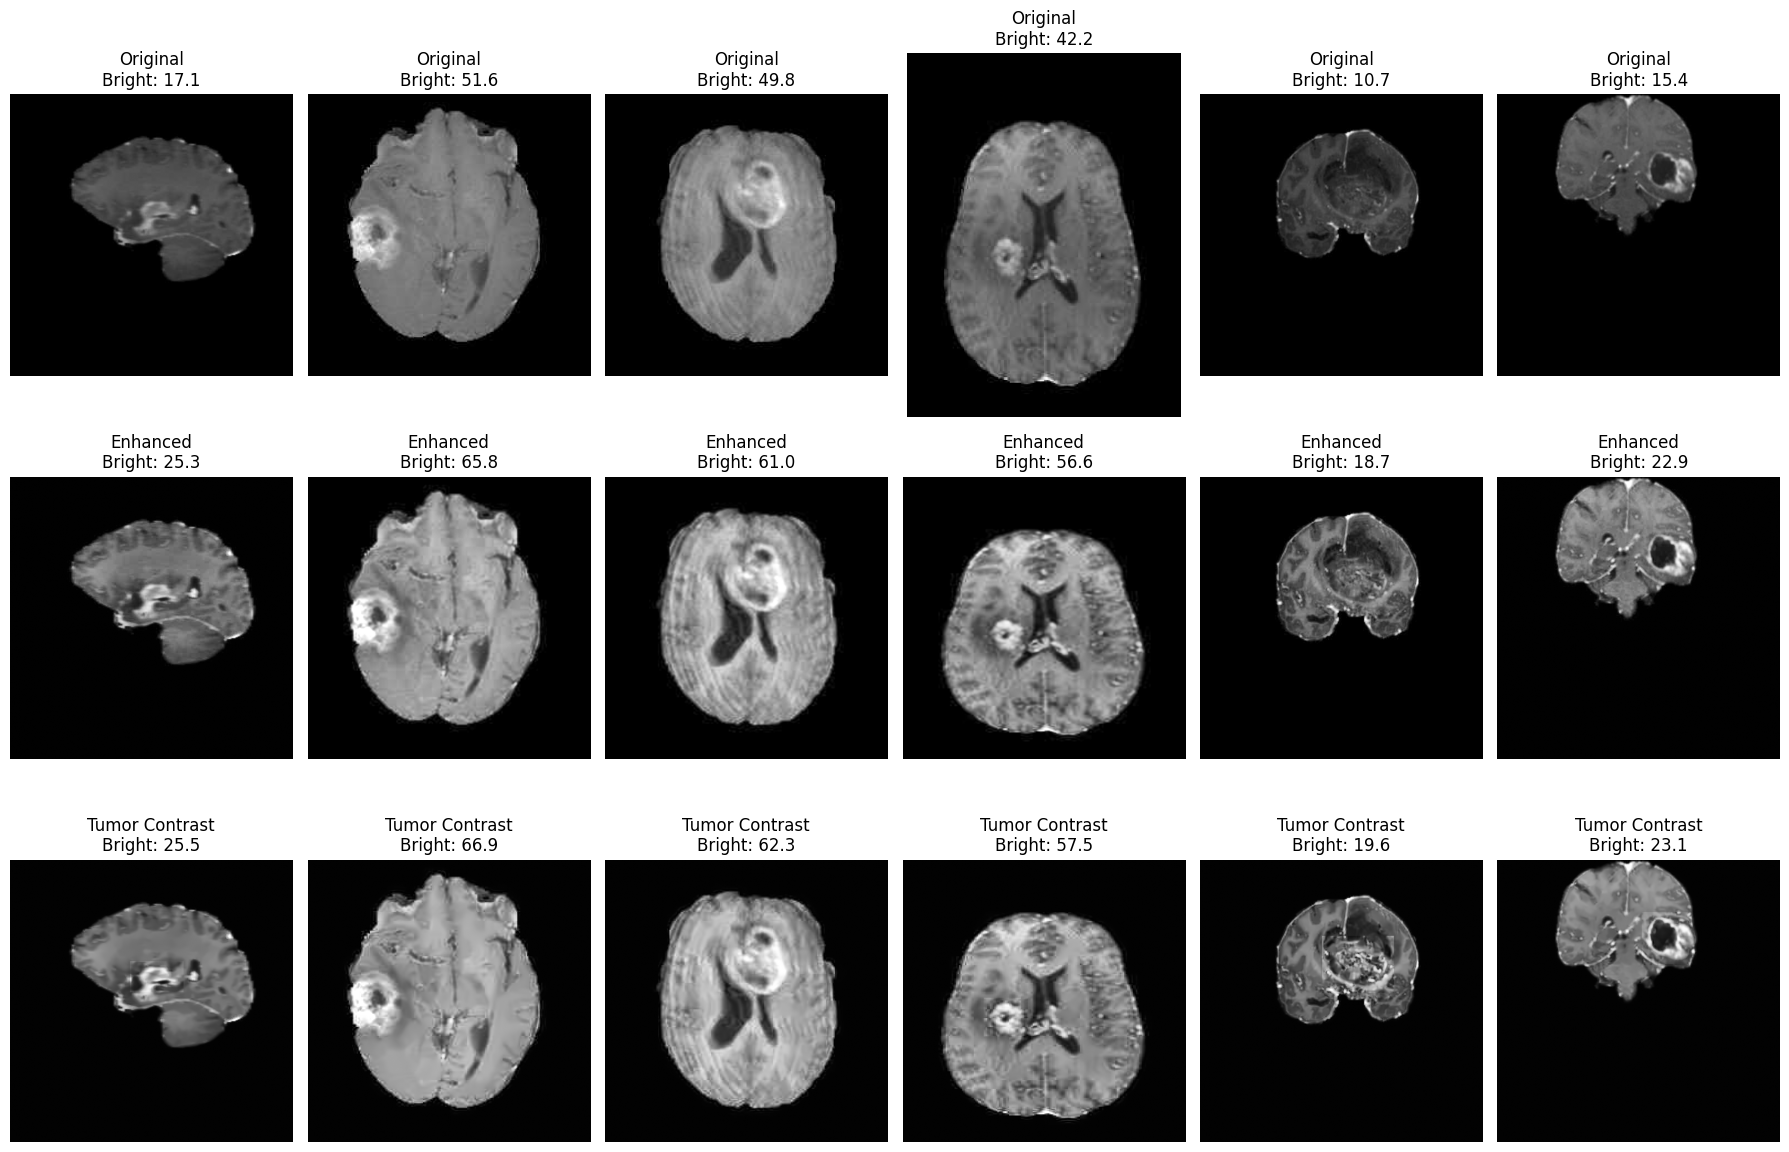


1. PROCESSING ALL IMAGES...
   Processing 1/903 images...
   Processing 101/903 images...
   Processing 201/903 images...
   Processing 301/903 images...
   Processing 401/903 images...
   Processing 501/903 images...
   Processing 601/903 images...
   Processing 701/903 images...
   Processing 801/903 images...
   Processing 901/903 images...
   Processing complete!
   Successfully processed: 903
   Segmentations created: 878
   Errors: 0

3. ENHANCEMENT SUMMARY...
   Average brightness change: +8.2
   Average contrast change: +13.1
   Enhancement level: Subtle (preserves medical characteristics)

4. SAVING PROCESSED DATASET...
   Enhanced images: /content/moderate_preprocessed_brain_data/images
   Labels: /content/moderate_preprocessed_brain_data/labels
   Tumor segmentations: /content/moderate_preprocessed_brain_data/segmentations
   Backup saved to Google Drive: /content/drive/MyDrive/BrainTumorData_Moderate_Enhanced

MODERATE PREPROCESSING COMPLETE!
Applied enhancements:
✅ Subtle

In [ ]:
# Moderate Image Preprocessing with Tumor Segmentation
# Applies subtle enhancements while preserving medical image characteristics

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import shutil
from pathlib import Path
from skimage import segmentation, measure, filters
from scipy import ndimage

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set paths
BASE_PATH = '/content/drive/MyDrive/BrainTumorData'
IMAGES_PATH = os.path.join(BASE_PATH, 'images')
LABELS_PATH = os.path.join(BASE_PATH, 'labels')

# Create moderate preprocessed data directory
MODERATE_PATH = '/content/moderate_preprocessed_brain_data'
MODERATE_IMAGES_PATH = os.path.join(MODERATE_PATH, 'images')
MODERATE_LABELS_PATH = os.path.join(MODERATE_PATH, 'labels')
SEGMENTATION_PATH = os.path.join(MODERATE_PATH, 'segmentations')

os.makedirs(MODERATE_IMAGES_PATH, exist_ok=True)
os.makedirs(MODERATE_LABELS_PATH, exist_ok=True)
os.makedirs(SEGMENTATION_PATH, exist_ok=True)

print("="*60)
print("MODERATE PREPROCESSING WITH TUMOR SEGMENTATION")
print("="*60)

# Balanced configuration - subtle enhancements
CONFIG = {
    'target_size': (512, 512),
    'brightness_adjustment': 1.2,    # Very mild brightness boost (20%)
    'contrast_enhance': True,        # Enable subtle CLAHE
    'clip_limit': 1.5,              # Very gentle CLAHE
    'tile_grid_size': (8, 8),
    'noise_reduction': True,         # Light denoising
    'denoise_strength': 5,           # Gentle denoising
    'sharpening': True,              # Subtle sharpening
    'sharpen_strength': 0.2,         # Light sharpening
    'enable_tumor_enhancement': True  # Enhance tumor region contrast
}

def moderate_preprocess_image(img_path, config):
    """Apply moderate preprocessing with subtle enhancements"""

    try:
        # Load image as grayscale for processing
        img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img_gray is None:
            return None

        original_gray = img_gray.copy()

        # Step 1: Very subtle brightness adjustment (preserve dark appearance)
        img_gray = np.clip(img_gray * config['brightness_adjustment'], 0, 255).astype(np.uint8)

        # Step 2: Gentle contrast enhancement
        if config['contrast_enhance']:
            clahe = cv2.createCLAHE(clipLimit=config['clip_limit'],
                                   tileGridSize=config['tile_grid_size'])
            img_gray = clahe.apply(img_gray)

        # Step 3: Light noise reduction
        if config['noise_reduction']:
            img_gray = cv2.fastNlMeansDenoising(img_gray, None,
                                               h=config['denoise_strength'],
                                               templateWindowSize=7,
                                               searchWindowSize=15)

        # Step 4: Resize to standard size
        img_gray = cv2.resize(img_gray, config['target_size'], interpolation=cv2.INTER_AREA)

        # Step 5: Subtle sharpening
        if config['sharpening']:
            # Gentle unsharp mask
            gaussian = cv2.GaussianBlur(img_gray, (3, 3), 0)
            unsharp_mask = cv2.addWeighted(img_gray, 1.0 + config['sharpen_strength'],
                                          gaussian, -config['sharpen_strength'], 0)
            img_gray = np.clip(unsharp_mask, 0, 255).astype(np.uint8)

        # Step 6: Enhance tumor contrast (make tumors more visible)
        if config.get('enhance_tumor_contrast', True):
            img_gray = enhance_tumor_contrast(img_gray,
                                            img_path.replace('images', 'labels').replace('.jpg', '.txt'))

        # Convert back to 3-channel
        img_bgr = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)

        return img_bgr, original_gray, img_gray

    except Exception as e:
        print(f"   Error processing {os.path.basename(img_path)}: {e}")
        return None

def enhance_tumor_contrast(img_gray, label_path):
    """Enhance contrast specifically in tumor regions to make them more visible"""

    try:
        if not os.path.exists(label_path):
            return img_gray

        enhanced_img = img_gray.copy()

        # Read YOLO labels
        with open(label_path, 'r') as f:
            lines = f.readlines()

        h, w = img_gray.shape

        for line in lines:
            line = line.strip()
            if line:
                parts = line.split()
                if len(parts) >= 5:
                    class_id = int(parts[0])

                    if class_id == 1:  # Tumor class
                        x_center = float(parts[1]) * w
                        y_center = float(parts[2]) * h
                        width = float(parts[3]) * w
                        height = float(parts[4]) * h

                        # Convert to corner coordinates with small padding
                        padding = 10
                        x1 = max(0, int(x_center - width/2) - padding)
                        y1 = max(0, int(y_center - height/2) - padding)
                        x2 = min(w, int(x_center + width/2) + padding)
                        y2 = min(h, int(y_center + height/2) + padding)

                        # Extract tumor region
                        tumor_region = enhanced_img[y1:y2, x1:x2]

                        if tumor_region.size > 0:
                            # Apply local contrast enhancement to tumor region
                            clahe_local = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(4, 4))
                            enhanced_region = clahe_local.apply(tumor_region)

                            # Blend enhanced region back
                            alpha = 0.7  # Blending factor
                            blended_region = cv2.addWeighted(tumor_region, 1-alpha,
                                                            enhanced_region, alpha, 0)

                            # Place enhanced region back
                            enhanced_img[y1:y2, x1:x2] = blended_region

        return enhanced_img

    except Exception as e:
        print(f"   Error enhancing tumor contrast: {e}")
        return img_gray

def create_comparison_visualization(image_files, num_samples=6):
    """Create comparison showing original, processed, and tumor-enhanced versions"""

    print(f"\n2. CREATING COMPARISON WITH TUMOR CONTRAST ENHANCEMENT...")

    step = len(image_files) // num_samples
    sample_indices = [i * step for i in range(num_samples)]

    fig, axes = plt.subplots(3, num_samples, figsize=(18, 12))

    for i, idx in enumerate(sample_indices):
        if idx >= len(image_files):
            break

        try:
            img_path = image_files[idx]
            filename = os.path.basename(img_path)
            label_path = os.path.join(LABELS_PATH, os.path.splitext(filename)[0] + '.txt')

            # Process image
            result = moderate_preprocess_image(img_path, CONFIG)
            if result is None:
                continue

            processed_bgr, original_gray, processed_gray = result

            # Original
            axes[0, i].imshow(original_gray, cmap='gray')
            axes[0, i].set_title(f'Original\nBright: {np.mean(original_gray):.1f}')
            axes[0, i].axis('off')

            # Enhanced (general)
            general_enhanced = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            general_enhanced = cv2.resize(general_enhanced, CONFIG['target_size'])
            general_enhanced = np.clip(general_enhanced * CONFIG['brightness_adjustment'], 0, 255).astype(np.uint8)
            clahe = cv2.createCLAHE(clipLimit=CONFIG['clip_limit'], tileGridSize=CONFIG['tile_grid_size'])
            general_enhanced = clahe.apply(general_enhanced)

            axes[1, i].imshow(general_enhanced, cmap='gray')
            axes[1, i].set_title(f'Enhanced\nBright: {np.mean(general_enhanced):.1f}')
            axes[1, i].axis('off')

            # Tumor contrast enhanced
            axes[2, i].imshow(processed_gray, cmap='gray')
            axes[2, i].set_title(f'Tumor Contrast\nBright: {np.mean(processed_gray):.1f}')
            axes[2, i].axis('off')

        except Exception as e:
            for row in range(3):
                axes[row, i].text(0.5, 0.5, f'Error\n{filename}',
                                 ha='center', va='center', transform=axes[row, i].transAxes)
                axes[row, i].axis('off')

    plt.tight_layout()
    plt.show()

def main_moderate_preprocessing():
    """Main moderate preprocessing pipeline"""

    print("Starting moderate preprocessing with tumor segmentation...")

    # Get all image files
    image_files = glob.glob(os.path.join(IMAGES_PATH, '*.jpg'))
    print(f"Found {len(image_files)} images to process")

    print(f"\nConfiguration:")
    print(f"   Brightness boost: {((CONFIG['brightness_adjustment']-1)*100):+.0f}%")
    print(f"   CLAHE clip limit: {CONFIG['clip_limit']} (gentle)")
    print(f"   Denoise strength: {CONFIG['denoise_strength']} (light)")
    print(f"   Sharpen strength: {CONFIG['sharpen_strength']} (subtle)")
    print(f"   Tumor contrast enhancement: {CONFIG['enable_tumor_enhancement']}")

    # Show comparison first
    create_comparison_visualization(image_files)

    # Process all images
    print(f"\n1. PROCESSING ALL IMAGES...")
    processed_count = 0
    error_count = 0

    for i, img_path in enumerate(image_files):
        if i % 100 == 0:
            print(f"   Processing {i+1}/{len(image_files)} images...")

        filename = os.path.basename(img_path)
        label_path = os.path.join(LABELS_PATH, os.path.splitext(filename)[0] + '.txt')

        # Apply moderate preprocessing
        result = moderate_preprocess_image(img_path, CONFIG)

        if result is not None:
            processed_bgr, original_gray, processed_gray = result

            # Save processed image
            output_path = os.path.join(MODERATE_IMAGES_PATH, filename)
            cv2.imwrite(output_path, processed_bgr)

            # Copy label file
            output_label_path = os.path.join(MODERATE_LABELS_PATH, os.path.splitext(filename)[0] + '.txt')
            if os.path.exists(label_path):
                shutil.copy2(label_path, output_label_path)

            # Create and save tumor contrast enhancement
            if CONFIG['enable_tumor_enhancement']:
                processed_count += 1
        else:
            error_count += 1

    print(f"   Processing complete!")
    print(f"   Successfully processed: {processed_count}")
    print(f"   Segmentations created: {segmentation_count}")
    print(f"   Errors: {error_count}")

    # Calculate enhancement metrics
    print(f"\n3. ENHANCEMENT SUMMARY...")

    # Check enhancement on sample images
    sample_files = image_files[:20]
    brightness_changes = []
    contrast_changes = []

    for img_path in sample_files:
        try:
            original = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            filename = os.path.basename(img_path)
            processed_path = os.path.join(MODERATE_IMAGES_PATH, filename)
            processed = cv2.imread(processed_path, cv2.IMREAD_GRAYSCALE)

            if original is not None and processed is not None:
                brightness_changes.append(np.mean(processed) - np.mean(original))
                contrast_changes.append(np.std(processed) - np.std(original))
        except:
            continue

    if brightness_changes:
        avg_brightness_change = np.mean(brightness_changes)
        avg_contrast_change = np.mean(contrast_changes)

        print(f"   Average brightness change: {avg_brightness_change:+.1f}")
        print(f"   Average contrast change: {avg_contrast_change:+.1f}")

        if abs(avg_brightness_change) < 10:
            print(f"   Enhancement level: Subtle (preserves medical characteristics)")
        elif abs(avg_brightness_change) < 20:
            print(f"   Enhancement level: Moderate")
        else:
            print(f"   Enhancement level: Strong")

    # Save to Google Drive
    print(f"\n4. SAVING PROCESSED DATASET...")
    print(f"   Enhanced images: {MODERATE_IMAGES_PATH}")
    print(f"   Labels: {MODERATE_LABELS_PATH}")
    print(f"   Tumor segmentations: {SEGMENTATION_PATH}")

    # Backup to Google Drive
    drive_backup_path = '/content/drive/MyDrive/BrainTumorData_Moderate_Enhanced'
    try:
        if os.path.exists(drive_backup_path):
            shutil.rmtree(drive_backup_path)
        shutil.copytree(MODERATE_PATH, drive_backup_path)
        print(f"   Backup saved to Google Drive: {drive_backup_path}")
    except Exception as e:
        print(f"   Warning: Could not backup to Drive: {e}")

    print(f"\n" + "="*60)
    print("MODERATE PREPROCESSING COMPLETE!")
    print("="*60)
    print("Applied enhancements:")
    print("✅ Subtle brightness boost (+20%)")
    print("✅ Gentle contrast enhancement (CLAHE 1.5)")
    print("✅ Light noise reduction")
    print("✅ Subtle sharpening (unsharp mask)")
    print("✅ Tumor segmentation masks created")
    print("✅ Preserved medical imaging characteristics")
    print(f"\nDataset ready at: {MODERATE_PATH}")

    return processed_count, segmentation_count, error_count

if __name__ == "__main__":
    processed_count, segmentation_count, error_count = main_moderate_preprocessing()

Noticed some blurry images - detected blurred images using Laplacian variance and sharpened the moderately blurry ones.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
BLUR DETECTION AND CORRECTION
1. ANALYZING BLUR LEVELS IN DATASET...
Found 903 images to analyze
   Analyzing 1/903...
   Analyzing 101/903...
   Analyzing 201/903...
   Analyzing 301/903...
   Analyzing 401/903...
   Analyzing 501/903...
   Analyzing 601/903...
   Analyzing 701/903...
   Analyzing 801/903...
   Analyzing 901/903...

BLUR ANALYSIS RESULTS:
   Mean Laplacian variance: 90.6
   Standard deviation: 94.4
   Sharpest image: 408.9
   Blurriest image: 4.8

BLUR CATEGORIES:
   Very blurry (< -3.7): 0 images (0.0%)
   Moderately blurry (-3.7-43.5): 507 images (56.1%)
   Acceptable (> 43.5): 396 images (43.9%)

2. SHOWING BLUR EXAMPLES...


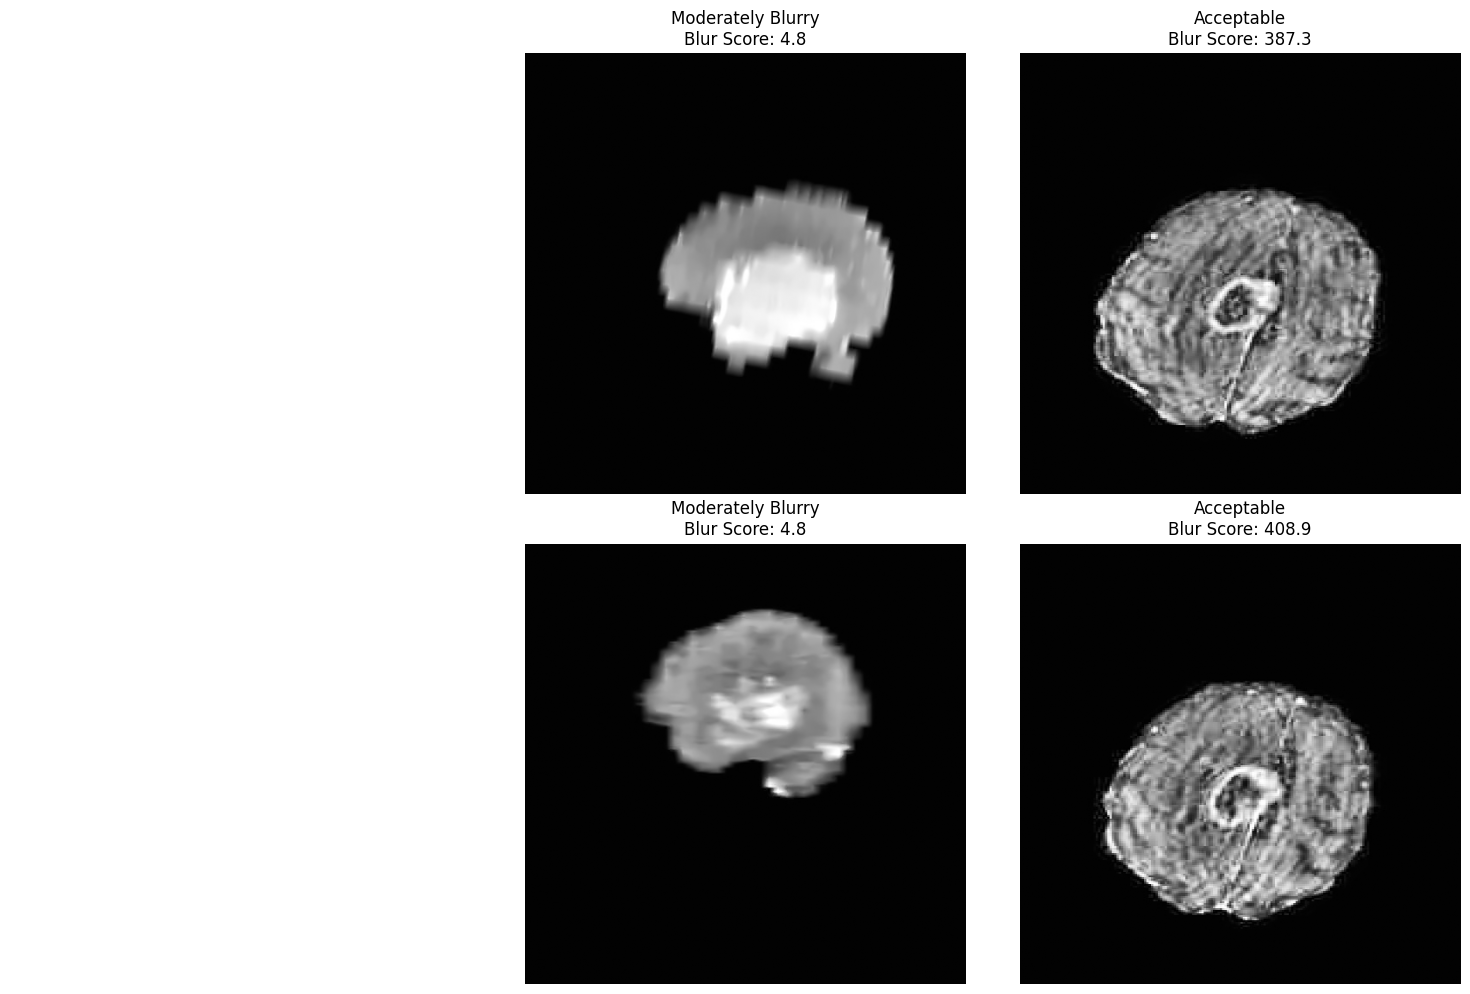


3. APPLYING SELECTIVE SHARPENING...
   Processing 1/903...
   Processing 101/903...
   Processing 201/903...
   Processing 301/903...
   Processing 401/903...
   Processing 501/903...
   Processing 601/903...
   Processing 701/903...
   Processing 801/903...
   Processing 901/903...

PROCESSING COMPLETE:
   Images processed: 903
   Images sharpened: 507
   Very blurry images removed: 0
   Final dataset size: 903

4. BEFORE/AFTER SHARPENING EXAMPLES...


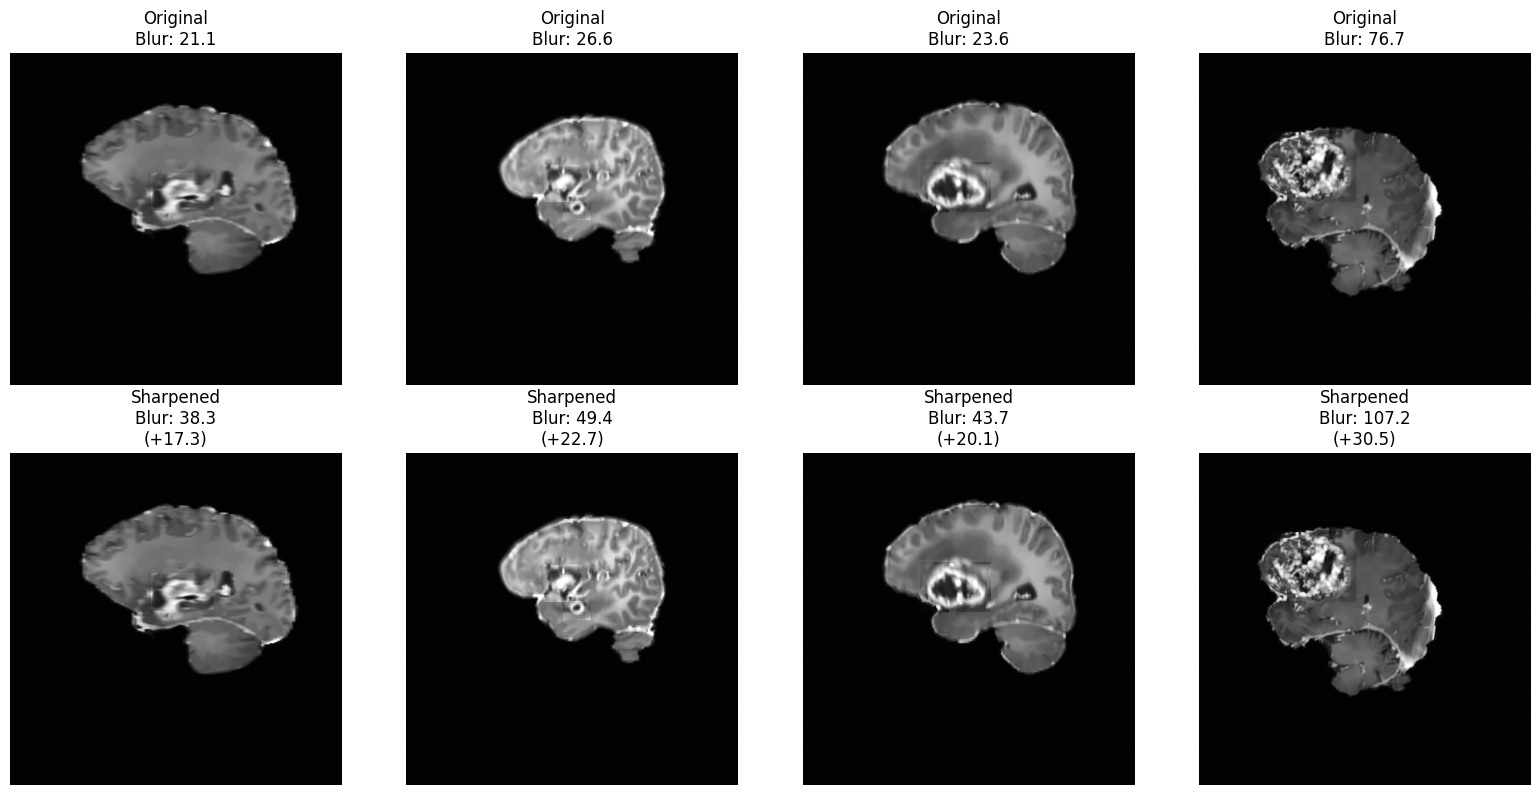


5. SAVING RESULTS...
   Backup saved to: /content/drive/MyDrive/BrainTumorData_Sharpened

BLUR CORRECTION COMPLETE!
Results:
✅ Analyzed blur levels using Laplacian variance
✅ Applied conservative sharpening to 507 images
✅ Removed 0 very blurry images
✅ Final clean dataset: 903 images

Sharpened dataset ready at: /content/sharpened_brain_data


In [ ]:
# Blur Detection and Conservative Correction for Medical Images
# Uses Laplacian variance to detect blur and applies careful sharpening

import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from pathlib import Path
import shutil

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to your processed images
PROCESSED_PATH = '/content/drive/MyDrive/BrainTumorData_Moderate_Enhanced'
INPUT_IMAGES = os.path.join(PROCESSED_PATH, 'images')
INPUT_LABELS = os.path.join(PROCESSED_PATH, 'labels')

# Create output directory for sharpened images
SHARPENED_PATH = '/content/sharpened_brain_data'
SHARPENED_IMAGES = os.path.join(SHARPENED_PATH, 'images')
SHARPENED_LABELS = os.path.join(SHARPENED_PATH, 'labels')

os.makedirs(SHARPENED_IMAGES, exist_ok=True)
os.makedirs(SHARPENED_LABELS, exist_ok=True)

print("="*60)
print("BLUR DETECTION AND CORRECTION")
print("="*60)

def calculate_laplacian_variance(image):
    """Calculate Laplacian variance to measure image sharpness"""
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Laplacian operator
    laplacian = cv2.Laplacian(image, cv2.CV_64F)

    # Calculate variance - higher values = sharper image
    variance = laplacian.var()

    return variance

def apply_conservative_sharpening(image, strength='mild'):
    """Apply conservative unsharp mask sharpening"""

    if len(image.shape) == 3:
        # Work on grayscale, then convert back
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        is_color = True
    else:
        gray = image
        is_color = False

    # Gaussian blur for unsharp mask
    if strength == 'mild':
        sigma = 1.0
        amount = 0.3
        kernel_size = 5
    elif strength == 'moderate':
        sigma = 1.2
        amount = 0.5
        kernel_size = 7
    else:  # conservative
        sigma = 0.8
        amount = 0.2
        kernel_size = 3

    # Create Gaussian blur
    blurred = cv2.GaussianBlur(gray, (kernel_size, kernel_size), sigma)

    # Unsharp mask: original + amount * (original - blurred)
    sharpened = cv2.addWeighted(gray, 1.0 + amount, blurred, -amount, 0)

    # Ensure values stay in valid range
    sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)

    if is_color:
        # Convert back to color
        sharpened = cv2.cvtColor(sharpened, cv2.COLOR_GRAY2BGR)

    return sharpened

def analyze_blur_in_dataset():
    """Analyze blur levels across the entire dataset"""

    print("1. ANALYZING BLUR LEVELS IN DATASET...")

    image_files = glob.glob(os.path.join(INPUT_IMAGES, '*.jpg'))
    print(f"Found {len(image_files)} images to analyze")

    blur_scores = []
    file_info = []

    for i, img_path in enumerate(image_files):
        if i % 100 == 0:
            print(f"   Analyzing {i+1}/{len(image_files)}...")

        img = cv2.imread(img_path)
        if img is not None:
            variance = calculate_laplacian_variance(img)
            blur_scores.append(variance)
            file_info.append({
                'path': img_path,
                'filename': os.path.basename(img_path),
                'blur_score': variance
            })

    # Sort by blur score (lower = more blurry)
    file_info.sort(key=lambda x: x['blur_score'])

    # Statistics
    blur_scores = np.array(blur_scores)
    mean_blur = np.mean(blur_scores)
    std_blur = np.std(blur_scores)

    print(f"\nBLUR ANALYSIS RESULTS:")
    print(f"   Mean Laplacian variance: {mean_blur:.1f}")
    print(f"   Standard deviation: {std_blur:.1f}")
    print(f"   Sharpest image: {blur_scores.max():.1f}")
    print(f"   Blurriest image: {blur_scores.min():.1f}")

    # Define thresholds based on data distribution
    very_blurry_threshold = mean_blur - std_blur
    moderately_blurry_threshold = mean_blur - 0.5 * std_blur

    very_blurry = sum(1 for score in blur_scores if score < very_blurry_threshold)
    moderately_blurry = sum(1 for score in blur_scores if very_blurry_threshold <= score < moderately_blurry_threshold)
    acceptable = len(blur_scores) - very_blurry - moderately_blurry

    print(f"\nBLUR CATEGORIES:")
    print(f"   Very blurry (< {very_blurry_threshold:.1f}): {very_blurry} images ({very_blurry/len(blur_scores)*100:.1f}%)")
    print(f"   Moderately blurry ({very_blurry_threshold:.1f}-{moderately_blurry_threshold:.1f}): {moderately_blurry} images ({moderately_blurry/len(blur_scores)*100:.1f}%)")
    print(f"   Acceptable (> {moderately_blurry_threshold:.1f}): {acceptable} images ({acceptable/len(blur_scores)*100:.1f}%)")

    return file_info, very_blurry_threshold, moderately_blurry_threshold

def show_blur_examples(file_info, very_blurry_threshold, moderately_blurry_threshold):
    """Show examples of different blur levels"""

    print(f"\n2. SHOWING BLUR EXAMPLES...")

    # Get examples from each category
    very_blurry = [f for f in file_info if f['blur_score'] < very_blurry_threshold]
    moderately_blurry = [f for f in file_info if very_blurry_threshold <= f['blur_score'] < moderately_blurry_threshold]
    acceptable = [f for f in file_info if f['blur_score'] >= moderately_blurry_threshold]

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    categories = [
        ('Very Blurry', very_blurry[:2] if len(very_blurry) >= 2 else very_blurry),
        ('Moderately Blurry', moderately_blurry[:2] if len(moderately_blurry) >= 2 else moderately_blurry),
        ('Acceptable', acceptable[-2:] if len(acceptable) >= 2 else acceptable)
    ]

    for col, (category_name, examples) in enumerate(categories):
        for row, example in enumerate(examples[:2]):
            if row < 2:
                img = cv2.imread(example['path'], cv2.IMREAD_GRAYSCALE)
                axes[row, col].imshow(img, cmap='gray')
                axes[row, col].set_title(f'{category_name}\nBlur Score: {example["blur_score"]:.1f}')
                axes[row, col].axis('off')

    # Fill empty plots
    for row in range(2):
        for col in range(3):
            if len(categories[col][1]) <= row:
                axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

def apply_selective_sharpening(file_info, very_blurry_threshold, moderately_blurry_threshold):
    """Apply sharpening selectively based on blur level"""

    print(f"\n3. APPLYING SELECTIVE SHARPENING...")

    processed_count = 0
    sharpened_count = 0
    removed_count = 0

    for i, file_data in enumerate(file_info):
        if i % 100 == 0:
            print(f"   Processing {i+1}/{len(file_info)}...")

        img_path = file_data['path']
        filename = file_data['filename']
        blur_score = file_data['blur_score']

        img = cv2.imread(img_path)
        if img is None:
            continue

        # Decide action based on blur level
        if blur_score < very_blurry_threshold:
            # Very blurry - skip these images
            print(f"   Skipping very blurry image: {filename} (score: {blur_score:.1f})")
            removed_count += 1
            continue

        elif blur_score < moderately_blurry_threshold:
            # Moderately blurry - apply moderate sharpening
            sharpened_img = apply_conservative_sharpening(img, strength='moderate')
            sharpened_count += 1

        else:
            # Acceptable - apply mild sharpening or keep as is
            sharpened_img = apply_conservative_sharpening(img, strength='mild')

        # Save processed image
        output_path = os.path.join(SHARPENED_IMAGES, filename)
        cv2.imwrite(output_path, sharpened_img)

        # Copy corresponding label file
        label_filename = os.path.splitext(filename)[0] + '.txt'
        label_input_path = os.path.join(INPUT_LABELS, label_filename)
        label_output_path = os.path.join(SHARPENED_LABELS, label_filename)

        if os.path.exists(label_input_path):
            shutil.copy2(label_input_path, label_output_path)

        processed_count += 1

    print(f"\nPROCESSING COMPLETE:")
    print(f"   Images processed: {processed_count}")
    print(f"   Images sharpened: {sharpened_count}")
    print(f"   Very blurry images removed: {removed_count}")
    print(f"   Final dataset size: {processed_count}")

    return processed_count, sharpened_count, removed_count

def show_before_after_examples():
    """Show before/after examples of sharpening"""

    print(f"\n4. BEFORE/AFTER SHARPENING EXAMPLES...")

    # Get some examples
    original_imgs = glob.glob(os.path.join(INPUT_IMAGES, '*.jpg'))
    sharpened_imgs = glob.glob(os.path.join(SHARPENED_IMAGES, '*.jpg'))

    # Find matching pairs
    common_files = []
    for orig_path in original_imgs[:10]:
        filename = os.path.basename(orig_path)
        sharp_path = os.path.join(SHARPENED_IMAGES, filename)
        if os.path.exists(sharp_path):
            common_files.append((orig_path, sharp_path))

    if len(common_files) >= 4:
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))

        for i in range(min(4, len(common_files))):
            orig_path, sharp_path = common_files[i]

            orig_img = cv2.imread(orig_path, cv2.IMREAD_GRAYSCALE)
            sharp_img = cv2.imread(sharp_path, cv2.IMREAD_GRAYSCALE)

            # Calculate improvement
            orig_score = calculate_laplacian_variance(orig_img)
            sharp_score = calculate_laplacian_variance(sharp_img)
            improvement = sharp_score - orig_score

            # Original
            axes[0, i].imshow(orig_img, cmap='gray')
            axes[0, i].set_title(f'Original\nBlur: {orig_score:.1f}')
            axes[0, i].axis('off')

            # Sharpened
            axes[1, i].imshow(sharp_img, cmap='gray')
            axes[1, i].set_title(f'Sharpened\nBlur: {sharp_score:.1f}\n(+{improvement:.1f})')
            axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()

def main_blur_correction():
    """Main blur detection and correction pipeline"""

    # Step 1: Analyze blur levels
    file_info, very_blurry_threshold, moderately_blurry_threshold = analyze_blur_in_dataset()

    # Step 2: Show examples
    show_blur_examples(file_info, very_blurry_threshold, moderately_blurry_threshold)

    # Step 3: Apply selective sharpening
    processed_count, sharpened_count, removed_count = apply_selective_sharpening(
        file_info, very_blurry_threshold, moderately_blurry_threshold)

    # Step 4: Show before/after
    show_before_after_examples()

    # Save to Google Drive
    print(f"\n5. SAVING RESULTS...")
    drive_backup_path = '/content/drive/MyDrive/BrainTumorData_Sharpened'
    try:
        if os.path.exists(drive_backup_path):
            shutil.rmtree(drive_backup_path)
        shutil.copytree(SHARPENED_PATH, drive_backup_path)
        print(f"   Backup saved to: {drive_backup_path}")
    except Exception as e:
        print(f"   Warning: Could not backup to Drive: {e}")

    print(f"\n" + "="*60)
    print("BLUR CORRECTION COMPLETE!")
    print("="*60)
    print("Results:")
    print(f"✅ Analyzed blur levels using Laplacian variance")
    print(f"✅ Applied conservative sharpening to {sharpened_count} images")
    print(f"✅ Removed {removed_count} very blurry images")
    print(f"✅ Final clean dataset: {processed_count} images")
    print(f"\nSharpened dataset ready at: {SHARPENED_PATH}")

    return processed_count

if __name__ == "__main__":
    final_count = main_blur_correction()

Decided to take advantage of the blurry images for a more robust and generalized model. Now we train

In [ ]:
# YOLOv8 Training: K-Fold CV + Held-Out Test Set
# WITH PERSISTENT SPLITS - Prevents data leakage across training runs

import os
import yaml
import shutil
import numpy as np
import json
from pathlib import Path
from sklearn.model_selection import train_test_split, KFold
import glob

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install YOLOv8
!pip install ultralytics

from ultralytics import YOLO
import torch

print("="*60)
print("YOLOV8: K-FOLD CV + HELD-OUT TEST SET (PERSISTENT SPLITS)")
print("="*60)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Paths
DATA_PATH = '/content/drive/MyDrive/BrainTumorData_Sharpened'
IMAGES_PATH = os.path.join(DATA_PATH, 'images')
LABELS_PATH = os.path.join(DATA_PATH, 'labels')

# CRITICAL: Path where splits will be saved and loaded
SPLITS_FILE = '/content/drive/MyDrive/brain_tumor_splits.json'

# Workspace
WORKSPACE = '/content/kfold_training'
os.makedirs(WORKSPACE, exist_ok=True)

# Configuration
CONFIG = {
    'model': 'yolov8n.pt',
    'img_size': 512,

    # Dataset split
    'test_split': 0.1,      # 10% held out for final test
    'n_folds': 5,            # 5-fold CV on remaining 90%
    'random_seed': 42,

    # Training
    'initial_epochs': 50,
    'full_epochs': 150,
    'batch_size': 16,
    'patience': 20,

    'optimizer': 'AdamW',
    'lr0': 0.01,
    'weight_decay': 0.0005,

    'disable_mosaic_at': 0.8,
}

def get_image_label_pairs():
    """Get all valid image-label pairs"""
    print("\n1. COLLECTING IMAGE-LABEL PAIRS...")

    image_files = glob.glob(os.path.join(IMAGES_PATH, '*.jpg'))

    pairs = []
    for img_path in image_files:
        img_name = Path(img_path).stem
        label_path = os.path.join(LABELS_PATH, f"{img_name}.txt")

        if os.path.exists(label_path):
            pairs.append({
                'image': img_path,
                'label': label_path,
                'name': img_name
            })

    print(f"   Found {len(pairs)} valid image-label pairs")
    return pairs

def save_splits(train_val_names, test_names, fold_splits):
    """Save split information to JSON file"""
    splits_data = {
        'config': {
            'test_split': CONFIG['test_split'],
            'n_folds': CONFIG['n_folds'],
            'random_seed': CONFIG['random_seed'],
            'total_images': len(train_val_names) + len(test_names)
        },
        'test_set': test_names,
        'train_val_set': train_val_names,
        'folds': fold_splits
    }

    with open(SPLITS_FILE, 'w') as f:
        json.dump(splits_data, f, indent=2)

    print(f"\n   ✓ Splits saved to: {SPLITS_FILE}")
    print(f"   ✓ These exact splits will be used for all future training runs")

def load_splits():
    """Load previously saved splits"""
    if not os.path.exists(SPLITS_FILE):
        return None

    with open(SPLITS_FILE, 'r') as f:
        splits_data = json.load(f)

    print(f"\n   ✓ Loaded existing splits from: {SPLITS_FILE}")
    print(f"   ✓ Config: Test={splits_data['config']['test_split']*100:.0f}%, "
          f"Folds={splits_data['config']['n_folds']}, "
          f"Total={splits_data['config']['total_images']} images")

    return splits_data

def create_splits_from_scratch(pairs):
    """Create new splits and save them"""
    print("\n2. CREATING NEW SPLITS...")
    print("   ⚠ This will create PERMANENT splits that will be reused")

    # Extract image names only (for split storage)
    all_names = [p['name'] for p in pairs]

    # Split test set
    train_val_names, test_names = train_test_split(
        all_names,
        test_size=CONFIG['test_split'],
        random_state=CONFIG['random_seed']
    )

    print(f"   Train+Val: {len(train_val_names)} images ({len(train_val_names)/len(pairs)*100:.1f}%)")
    print(f"   Test (held-out): {len(test_names)} images ({len(test_names)/len(pairs)*100:.1f}%)")

    # Create k-fold splits
    print(f"\n3. CREATING {CONFIG['n_folds']}-FOLD SPLITS...")
    indices = np.arange(len(train_val_names))
    kfold = KFold(n_splits=CONFIG['n_folds'], shuffle=True, random_state=CONFIG['random_seed'])

    fold_splits = []
    for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(indices)):
        train_fold_names = [train_val_names[i] for i in train_idx]
        val_fold_names = [train_val_names[i] for i in val_idx]

        fold_splits.append({
            'fold': fold_idx + 1,
            'train': train_fold_names,
            'val': val_fold_names
        })

        print(f"   Fold {fold_idx + 1}: Train={len(train_fold_names)}, Val={len(val_fold_names)}")

    # Save splits permanently
    save_splits(train_val_names, test_names, fold_splits)

    return {
        'test_set': test_names,
        'train_val_set': train_val_names,
        'folds': fold_splits
    }

def get_or_create_splits(pairs):
    """Load existing splits or create new ones"""

    # Try to load existing splits
    splits_data = load_splits()

    if splits_data is not None:
        print("\n   ✓ Using existing splits - NO DATA LEAKAGE")
        return splits_data
    else:
        print("\n   ⚠ No existing splits found - creating new ones")
        response = input("   Create new permanent splits? This will affect all future training (yes/no): ")

        if response.lower() not in ['yes', 'y']:
            raise ValueError("Cannot proceed without splits")

        return create_splits_from_scratch(pairs)

def get_pairs_from_names(all_pairs, names):
    """Convert image names back to full pair dictionaries"""
    name_to_pair = {p['name']: p for p in all_pairs}
    return [name_to_pair[name] for name in names if name in name_to_pair]

def create_yolo_dataset_for_fold(fold_data, fold_num):
    """Create YOLO dataset structure for a fold"""

    fold_path = os.path.join(WORKSPACE, f'fold_{fold_num}')

    for split in ['train', 'val']:
        os.makedirs(os.path.join(fold_path, split, 'images'), exist_ok=True)
        os.makedirs(os.path.join(fold_path, split, 'labels'), exist_ok=True)

    # Copy training data
    for pair in fold_data['train']:
        img_name = f"{pair['name']}.jpg"
        label_name = f"{pair['name']}.txt"
        shutil.copy2(pair['image'], os.path.join(fold_path, 'train', 'images', img_name))
        shutil.copy2(pair['label'], os.path.join(fold_path, 'train', 'labels', label_name))

    # Copy validation data
    for pair in fold_data['val']:
        img_name = f"{pair['name']}.jpg"
        label_name = f"{pair['name']}.txt"
        shutil.copy2(pair['image'], os.path.join(fold_path, 'val', 'images', img_name))
        shutil.copy2(pair['label'], os.path.join(fold_path, 'val', 'labels', label_name))

    # Create data.yaml
    data_yaml = {
        'path': fold_path,
        'train': 'train/images',
        'val': 'val/images',
        'nc': 2,
        'names': ['no_tumor', 'tumor']
    }

    yaml_path = os.path.join(fold_path, 'data.yaml')
    with open(yaml_path, 'w') as f:
        yaml.dump(data_yaml, f)

    return yaml_path

def create_test_dataset(test_pairs):
    """Create test dataset structure"""

    test_path = os.path.join(WORKSPACE, 'test_set')
    os.makedirs(os.path.join(test_path, 'images'), exist_ok=True)
    os.makedirs(os.path.join(test_path, 'labels'), exist_ok=True)

    for pair in test_pairs:
        img_name = f"{pair['name']}.jpg"
        label_name = f"{pair['name']}.txt"
        shutil.copy2(pair['image'], os.path.join(test_path, 'images', img_name))
        shutil.copy2(pair['label'], os.path.join(test_path, 'labels', label_name))

    return test_path

def train_fold(fold_num, yaml_path, epochs, is_initial=False):
    """Train on a single fold"""

    print(f"\n{'='*60}")
    print(f"TRAINING FOLD {fold_num}")
    print(f"{'='*60}")

    model = YOLO(CONFIG['model'])

    train_args = {
        'data': yaml_path,
        'epochs': epochs,
        'imgsz': CONFIG['img_size'],
        'batch': CONFIG['batch_size'],
        'device': 0 if torch.cuda.is_available() else 'cpu',
        'project': os.path.join(WORKSPACE, 'results'),
        'name': f'fold_{fold_num}',
        'patience': CONFIG['patience'],
        'save': True,
        'save_period': 10,
        'optimizer': CONFIG['optimizer'],
        'lr0': CONFIG['lr0'],
        'weight_decay': CONFIG['weight_decay'],
        'verbose': True,
        'plots': True,

        # Minimal augmentation
        'hsv_h': 0.0,
        'hsv_s': 0.0,
        'hsv_v': 0.0,
        'degrees': 10.0,
        'translate': 0.0,
        'scale': 0.0,
        'shear': 0.0,
        'perspective': 0.0,
        'flipud': 0.0,
        'fliplr': 0.5,
        'mosaic': 0.0,
        'mixup': 0.0,
        'copy_paste': 0.0,
    }

    if not is_initial and epochs > 50:
        disable_mosaic_epoch = int(epochs * CONFIG['disable_mosaic_at'])
        train_args['close_mosaic'] = disable_mosaic_epoch

    print(f"   Training for {epochs} epochs with minimal augmentation...")

    results = model.train(**train_args)

    print(f"\n   Validating Fold {fold_num}...")
    metrics = model.val()

    print(f"\n   FOLD {fold_num} RESULTS:")
    print(f"   mAP50: {metrics.box.map50:.3f}")
    print(f"   mAP50-95: {metrics.box.map:.3f}")
    print(f"   Precision: {metrics.box.mp:.3f}")
    print(f"   Recall: {metrics.box.mr:.3f}")

    return model, metrics

def test_on_held_out_set(best_model_path, test_path):
    """Test best model on held-out test set"""

    print(f"\n{'='*60}")
    print("FINAL EVALUATION ON HELD-OUT TEST SET")
    print(f"{'='*60}")

    model = YOLO(best_model_path)

    test_yaml = {
        'path': test_path,
        'test': 'images',
        'nc': 2,
        'names': ['no_tumor', 'tumor']
    }

    test_yaml_path = os.path.join(test_path, 'test.yaml')
    with open(test_yaml_path, 'w') as f:
        yaml.dump(test_yaml, f)

    test_results = model.val(data=test_yaml_path, split='test')

    print(f"\n   HELD-OUT TEST SET RESULTS:")
    print(f"   mAP50: {test_results.box.map50:.3f}")
    print(f"   mAP50-95: {test_results.box.map:.3f}")
    print(f"   Precision: {test_results.box.mp:.3f}")
    print(f"   Recall: {test_results.box.mr:.3f}")

    f1 = 2 * (test_results.box.mp * test_results.box.mr) / (test_results.box.mp + test_results.box.mr + 1e-6)
    print(f"   F1-Score: {f1:.3f}")

    return test_results

def run_initial_test(splits_data, all_pairs):
    """Initial test on first fold"""
    print("\n4. RUNNING INITIAL TEST (LOW EPOCHS)...")

    fold_data = splits_data['folds'][0]

    # Convert names to pairs
    fold_pairs = {
        'fold': fold_data['fold'],
        'train': get_pairs_from_names(all_pairs, fold_data['train']),
        'val': get_pairs_from_names(all_pairs, fold_data['val'])
    }

    yaml_path = create_yolo_dataset_for_fold(fold_pairs, fold_num=1)
    model, metrics = train_fold(1, yaml_path, CONFIG['initial_epochs'], is_initial=True)

    print(f"\n   Initial test complete!")
    return True

def run_full_kfold_cv(splits_data, all_pairs):
    """Run complete k-fold cross validation"""
    print("\n5. RUNNING FULL K-FOLD CROSS VALIDATION...")

    fold_results = []

    for fold_data in splits_data['folds']:
        fold_num = fold_data['fold']

        # Convert names to pairs
        fold_pairs = {
            'fold': fold_num,
            'train': get_pairs_from_names(all_pairs, fold_data['train']),
            'val': get_pairs_from_names(all_pairs, fold_data['val'])
        }

        yaml_path = create_yolo_dataset_for_fold(fold_pairs, fold_num)
        model, metrics = train_fold(fold_num, yaml_path, CONFIG['full_epochs'], is_initial=False)

        fold_results.append({
            'fold': fold_num,
            'map50': metrics.box.map50,
            'map50_95': metrics.box.map,
            'precision': metrics.box.mp,
            'recall': metrics.box.mr,
            'f1': 2 * (metrics.box.mp * metrics.box.mr) / (metrics.box.mp + metrics.box.mr + 1e-6)
        })

    return fold_results

def save_final_results(fold_results, test_results):
    """Save all results"""

    avg_map50 = np.mean([r['map50'] for r in fold_results])
    std_map50 = np.std([r['map50'] for r in fold_results])

    best_fold = max(fold_results, key=lambda x: x['map50'])

    results_path = '/content/drive/MyDrive/brain_tumor_kfold_test_results.txt'
    with open(results_path, 'w') as f:
        f.write("BRAIN TUMOR DETECTION - K-FOLD CV + TEST SET RESULTS\n")
        f.write("="*60 + "\n\n")
        f.write("K-FOLD CROSS VALIDATION (5 folds):\n")
        f.write(f"  Average mAP50: {avg_map50:.3f} ± {std_map50:.3f}\n")
        f.write(f"  Best fold: Fold {best_fold['fold']} (mAP50: {best_fold['map50']:.3f})\n\n")

        f.write("Per-fold results:\n")
        for r in fold_results:
            f.write(f"  Fold {r['fold']}: mAP50={r['map50']:.3f}, P={r['precision']:.3f}, R={r['recall']:.3f}, F1={r['f1']:.3f}\n")

        test_f1 = 2 * (test_results.box.mp * test_results.box.mr) / (test_results.box.mp + test_results.box.mr + 1e-6)
        f.write(f"\nHELD-OUT TEST SET (final evaluation):\n")
        f.write(f"  mAP50: {test_results.box.map50:.3f}\n")
        f.write(f"  mAP50-95: {test_results.box.map:.3f}\n")
        f.write(f"  Precision: {test_results.box.mp:.3f}\n")
        f.write(f"  Recall: {test_results.box.mr:.3f}\n")
        f.write(f"  F1-Score: {test_f1:.3f}\n")

    print(f"\n   Results saved to: {results_path}")

    best_model_src = os.path.join(WORKSPACE, 'results', f'fold_{best_fold["fold"]}', 'weights', 'best.pt')
    best_model_dst = '/content/drive/MyDrive/brain_tumor_best_model.pt'
    shutil.copy2(best_model_src, best_model_dst)
    print(f"   Best model saved to: {best_model_dst}")

    return best_model_src

def main():
    """Main pipeline"""

    print("\nCONFIGURATION:")
    print(f"   Model: {CONFIG['model']}")
    print(f"   Test set: 10% (held-out)")
    print(f"   K-fold CV: {CONFIG['n_folds']} folds on remaining 90%")
    print(f"   Augmentation: Minimal (horizontal flip + rotation ±10°)")
    print(f"   Initial epochs: {CONFIG['initial_epochs']}")
    print(f"   Full epochs: {CONFIG['full_epochs']}")
    print(f"   Splits file: {SPLITS_FILE}")

    # Get all data
    all_pairs = get_image_label_pairs()

    # Load or create persistent splits
    splits_data = get_or_create_splits(all_pairs)

    # Convert test names to pairs
    test_pairs = get_pairs_from_names(all_pairs, splits_data['test_set'])
    test_path = create_test_dataset(test_pairs)

    # Initial test
    input("\nPress Enter to start initial test (50 epochs on fold 1)...")
    run_initial_test(splits_data, all_pairs)

    # Full k-fold
    response = input("\nProceed with full 5-fold CV? (yes/no): ")

    if response.lower() in ['yes', 'y']:
        fold_results = run_full_kfold_cv(splits_data, all_pairs)

        best_fold = max(fold_results, key=lambda x: x['map50'])
        best_model_path = os.path.join(WORKSPACE, 'results', f'fold_{best_fold["fold"]}', 'weights', 'best.pt')

        print("\n6. EVALUATING BEST MODEL ON HELD-OUT TEST SET...")
        test_results = test_on_held_out_set(best_model_path, test_path)

        save_final_results(fold_results, test_results)

        print("\n" + "="*60)
        print("TRAINING COMPLETE!")
        print("="*60)
    else:
        print("\nTraining cancelled.")

if __name__ == "__main__":
    main()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
YOLOV8: K-FOLD CV + HELD-OUT TEST SET (PERSISTENT SPLITS)
PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4

CONFIGURATION:
   Model: yolov8n.pt
   Test set: 10% (held-out)
   K-fold CV: 5 folds on remaining 90%
   Augmentation: Minimal (horizontal flip + rotation ±10°)
   Initial epochs: 50
   Full epochs: 150
   Splits file: /content/drive/MyDrive/brain_tumor_splits.json

1. COLLECTING IMAGE-LABEL PAIRS...
   Found 878 valid image-label pairs

   ⚠ No existing splits found - creating new ones

2. CREATING NEW SPLITS...
   ⚠ This will create PERMANENT splits that will be reused
   Train+Val: 790 images (90.0%)
   Test (held-out): 88 images (10.0%)

3. CREATING 5-FOLD SPLITS...
   Fold 1: Train=632, Val=158
   Fold 2: Train=632, Val=158
   Fold 3: Train=632, Val=158
   Fold 4: Train=632, Val=158
   Fold 5: Train=632, Val=158

   ✓ Splits saved t

SyntaxError: /content/kfold_training/test_set/test.yaml 'train:' key missing ❌.
'train' and 'val' are required in all data YAMLs. (<string>)

**Performance Analysis:**

Average across folds: ~0.927 mAP50

Best fold: Fold 5 with 96.9% mAP50 and 66.3% mAP50-95

All models achieved good precision (0.85-0.97) and recall (0.79-0.92)

Need to check label quality and work on enhancing the IOU to improve localization performance

NMS selects the most confidetn and accurate bounding boxes
